In [1]:
import numpy as np
import numpy.random as rnd

import pandas as pd

import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt

In [2]:
def powerlaw(t, exponent, x_min, x_max):
    """returns (normalization)t^{-exponent}"""
    area = (np.power(x_max, 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return np.power(t, -exponent)/area
    
# not used, but useful to understand how the loglog_powerlaw is written
def log_powerlaw(t, exponent, x_min, x_max):
    area = (np.power(x_max, 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return -exponent*np.log(t) - np.log(area)

def loglog_powerlaw(log_t, exponent, x_min, x_max):
    """Linear function of log(t)"""
    area = (np.power(x_max, 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return -exponent*log_t - np.log(area)

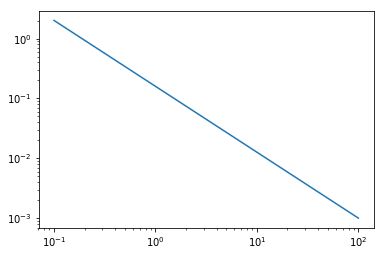

In [3]:
# check if the power law works

t_axis = np.linspace(0.1,100, 10000)
plt.plot(t_axis, powerlaw(t_axis, 1.1, 0.1, 100))
plt.xscale('log')
plt.yscale('log')

In [4]:
# adding also an exponential cut-off: P_cut(t) = (norm)t^{-p}*exp{-t/t_cut}

def powerlaw_cut(x, exponent, x_min, x_max, x_cut, strength):
    """returns P_cut(t) = (norm)t^{-p}*exp{-t/t_cut}"""
    # just modify the area formula in order to have an approximate normalization between x_min and x_cut 
    # (if x_cut < x_max, as it should be)
    area = (np.power(min(x_max,x_cut), 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return np.power(x, -exponent)* np.exp(-strength*x/x_cut)/area

def loglog_powerlaw_cut(log_x, exponent, x_min, x_max,x_cut, strength):
    """Linear function of log(x)"""
    area = (np.power(min(x_max,x_cut), 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return -exponent*log_x - strength*np.exp(log_x - np.log(x_cut)) - np.log(area)

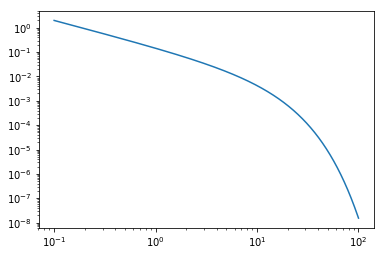

In [5]:
# check if the power law with cut-off works

t_axis = np.linspace(0.1,100, 10000)
plt.plot(t_axis, powerlaw_cut(t_axis, 1.1, 0.1, 100, 90, 10))
plt.xscale('log')
plt.yscale('log')

In [6]:
def generate_powerlaw(n_samples, exponent, x_min, x_max):
    P_x_min = powerlaw(x_min, exponent, x_min, x_max)
    P_x_max = powerlaw(x_max, exponent, x_min, x_max)
    
    #compute the extremes of the two axes in log-log space
    a = np.log(x_min)
    b = np.log(x_max)
    c = np.log(P_x_min)
    d = np.log(P_x_max)
    
    log_samples = np.zeros(n_samples)
    
    i = 0
    while (i < n_samples):
        
        #Montecarlo method for generating a powerlaw distribution in the rectangle [a,b]x[c,d]
        
        # u random variable in [a,b] ; u = log(t)
        u = (b - a) * rnd.random() + a
        # v random variable in [c,d] ; v = lot(P(t))
        v = (d - c) * rnd.random() + c

        if loglog_powerlaw(u, exponent, x_min, x_max) < v:
            
            # samples are random variables of log(t) with t distibuted as the given power law
            log_samples[i] = u
            i = i + 1
            
        else:
            continue
    
    samples = np.exp(log_samples)
    return samples

In [7]:
def generate_powerlaw_with_cutoff(n_samples, exponent, x_min, x_max, x_cut, strength):
    P_x_min = powerlaw(x_min, exponent, x_min, x_max)
    P_x_max = powerlaw(x_max, exponent, x_min, x_max)
    
    #compute the extremes of the two axes in log-log space
    a = np.log(x_min)
    b = np.log(x_max)
    c = np.log(P_x_min)
    d = np.log(P_x_max)
    
    log_samples = np.zeros(n_samples)
    
    i = 0
    while (i < n_samples):
        
        #Montecarlo method for generating a powerlaw distribution in the rectangle [a,b]x[c,d]
        
        # u random variable in [a,b] ; u = log(t)
        u = (b - a) * rnd.random() + a
        # v random variable in [c,d] ; v = lot(P(t))
        v = (d - c) * rnd.random() + c

        if loglog_powerlaw_cut(u, exponent, x_min, x_max, x_cut, strength) < v:
            
            # samples are random variables of log(t) with t distibuted as the given power law
            log_samples[i] = u
            i = i + 1
            
        else:
            continue
    
    samples = np.exp(log_samples)
    return samples

In [79]:
def binning(x, density = False):
    
    """Binning for power laws distributions.
        x = entries generated from a power law."""
    
    # x must have streactly positive values; x isn't normalized in general
    x = x[x>0]
    if density == True:
        x = x/x.max()
    
    # empirical method to get a good amount of bins (min 5), depending on the number of samples
    bin_extremes_number = max( min( int( np.log(len(x)) )*2 , 21), 6) 
    
    bin_extremes = np.exp(np.linspace(np.log(x.min()), np.log(x.max()), bin_extremes_number))
    
    widths = bin_extremes[1:] - bin_extremes[:-1]
    centers = (bin_extremes[1:] + bin_extremes[:-1])/2
    
    freq, _, _ = plt.hist(x, bins=bin_extremes)
    plt.close()
    
    # weights(bin_center) = Prob(bin_center) if normalized
    weights = freq/widths
    sigma_weights = np.sqrt(freq)/widths
    
    # merging of the first two bins until we get that the first bin represents the max of the PDF
    #this is done by removing the second extreme, thus the first bin becomes the one between 0 and 2
    widths = bin_extremes[1:] - bin_extremes[:-1]
    centers = (bin_extremes[1:] + bin_extremes[:-1])/2

    freq, _, _ = plt.hist(x, bins=bin_extremes)
    plt.close()
    weights = freq/widths
    sigma_weights = np.sqrt(freq)/widths
    
    
    
    return bin_extremes, widths, centers, freq, weights, sigma_weights   

In [80]:
def plot_powerlaw_hist(x, **kwargs):
    
    bin_extremes, widths, centers, freq, weights, sigma_weights = binning(x, **kwargs)
    bin_number = len(centers)

    plt.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
    plt.errorbar(centers, weights, sigma_weights, fmt = 'r.')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('normalized waiting times', fontsize = 14)
    plt.ylabel('occurrencies', fontsize = 14)
    plt.title('Number of events = {}'.format(len(x)))
    plt.show()

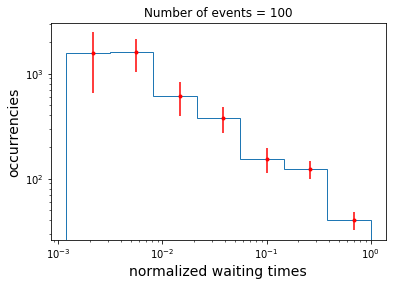

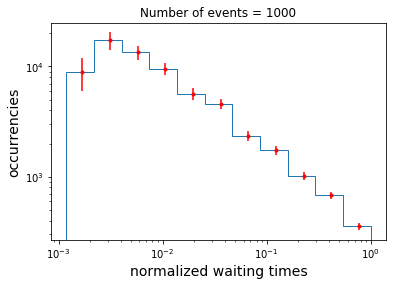

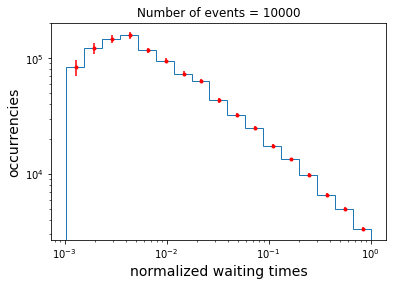

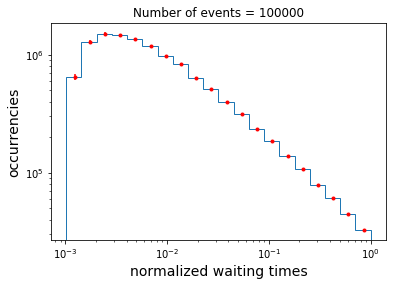

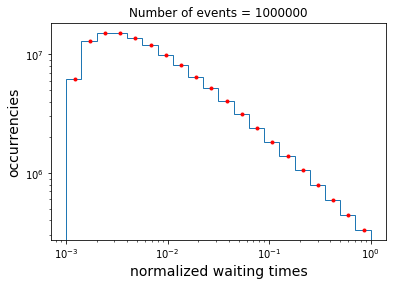

In [81]:
Ns = [10**i for i in range(2,7)]
for N in Ns:
    rnd_times = generate_powerlaw(n_samples = N, exponent = 1.1, x_min = 1, x_max = 1000)
    plot_powerlaw_hist(rnd_times, density = True)

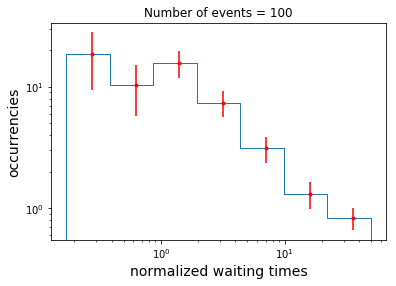

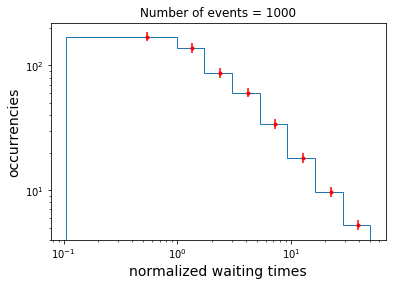

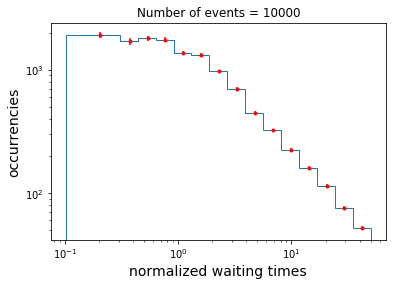

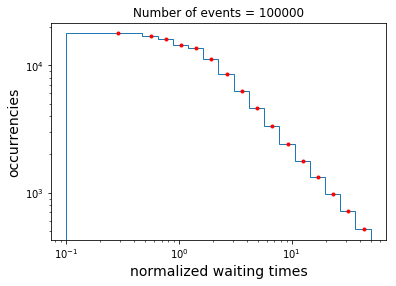

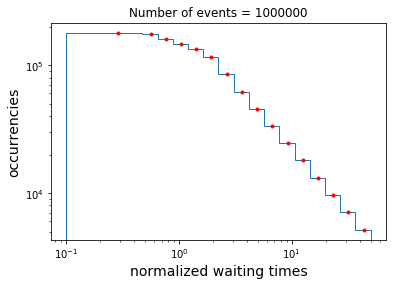

In [11]:
Ns = [10**i for i in range(2,7)]
for N in Ns:
    rnd_times = generate_powerlaw_with_cutoff(n_samples = N, exponent = 1.1, 
                                              x_min = 0.1, x_max = 50, x_cut = 50, strength = 100)
    # this parametrization of the cutoff isn't much convincing
    plot_powerlaw_hist(rnd_times)

## Now we try it with the real dataset

In [62]:
file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
data.shape

(110271,)

In [63]:
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

In [64]:
times = np.array(df['time'])
times.sort()
time_diff = times[1:] - times[:-1]
time_diff = time_diff[time_diff > 0]

In [65]:
x = binning(time_diff)

In [66]:
time_diff.sort()

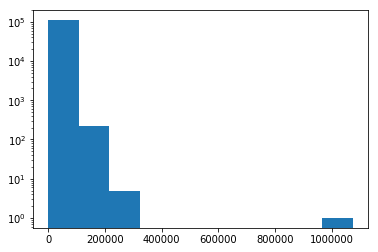

In [67]:
plt.hist(time_diff)
plt.yscale("log")

(110264,)
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.3000e+01 1.0000e+01 2.5000e+01 3.5000e+01 5.9000e+01
 9.3000e+01 2.6600e+02 6.4800e+02 1.7470e+03 3.8040e+03 6.4460e+03
 9.3560e+03 1.1810e+04 1.3410e+04 1.6151e+04 1.8482e+04 1.7006e+04
 8.9600e+03 1.8700e+03 7.2000e+01 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00]


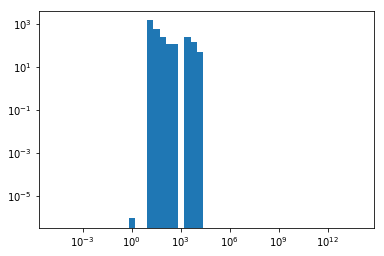

In [78]:
# log-scaled bins
bins = np.logspace(np.log(time_diff.min()), np.log(time_diff.max()), 50)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
#hist = np.histogram(time_diff, bins=bins)
# normalize by bin width
#hist_norm = hist[0]/widths

# plot it!
freq, _, _ = plt.hist(time_diff, bins=bins)
plt.close()
weights = freq/widths
plt.hist(freq, bins=bins, weights = weights)
plt.xscale('log')
plt.yscale('log')

In [72]:
weights.shape


(15,)

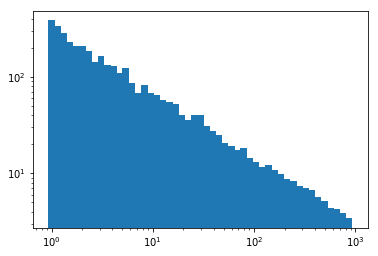

In [58]:
import numpy as np
from matplotlib import pyplot as plt

# something random to plot
data = (np.random.random(10000)*10)**3

# log-scaled bins
bins = np.logspace(0, 3, 50)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram(data, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')

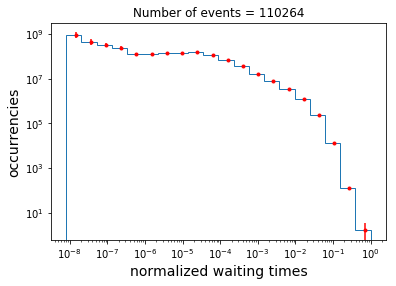

In [83]:

plot_powerlaw_hist(time_diff, density = True)

In [171]:
dfm = df[df['magnitude'] > 4]
times = np.array(dfm['time'])
times.sort()
time_diff = times[1:] - times[:-1]
time_diff = time_diff[time_diff > 0]
time_diff.sort()
time_diff[-5:]

array([ 9554028.26975989,  9732058.23456001, 12353529.73248002,
       12385447.44768   , 12434720.35680002])

8.111429697940723e-06


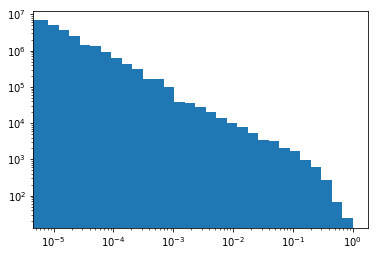

In [176]:
time_diff_norm = time_diff/time_diff.max()
first_decile = time_diff_norm[int(time_diff_norm.shape[0]*(1/20))]
print(first_decile)
bins = np.logspace(np.log10(first_decile), 0, 30)
bins = np.concatenate((np.array([0]), bins))
widths = (bins[1:] - bins[:-1])

# Calculate histogram
#hist = np.histogram(time_diff, bins=bins)
# normalize by bin width
#hist_norm = hist[0]/widths

# plot it!
freq, _, _ = plt.hist(time_diff_norm, bins=bins)
plt.close()
weights = freq/widths
centers = (bins[1:] + bins[:-1])/2
plt.hist(centers, bins=bins, weights = weights)
plt.xscale('log')
plt.yscale('log')

#plt.hist(time_diff[time_diff<2250], bins=100)
#plt.yscale("log")



(array([99., 35., 27., 19., 15., 13., 11.,  7.,  3., 13.]),
 array([1.20959997e+00, 2.25669024e+02, 4.50128448e+02, 6.74587872e+02,
        8.99047296e+02, 1.12350672e+03, 1.34796614e+03, 1.57242557e+03,
        1.79688499e+03, 2.02134442e+03, 2.24580384e+03]),
 <a list of 10 Patch objects>)

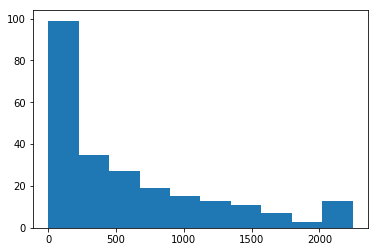

In [175]:
plt.hist(time_diff[time_diff<2250])